In [1]:
import os, sys
import ROOT as rt
import json
## user define
sys.path.append(".")
sys.path.append("./Utils")
from SystHelper import *
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
    
INPUTDIR = sys.argv[1]
ERA = sys.argv[2]
REGION = sys.argv[3]
ONLY_BENCHMARK = sys.argv[4]
ALL_MASSES = setting["ALL_MASSES"]
# # for dev
# INPUTDIR = "/eos/user/h/hkwon/SWAN_projects/Zpeak/Outputs/DNN/"
# # INPUTDIR = "/eos/user/h/hkwon/Run2/Preselection/20230830lep/DNN/"
# ERA = "ee17"
# INPUTDIR += ERA
# REGION = "SR"

Welcome to JupyROOT 6.28/06


In [2]:
def get_str_lumi_channel(era):
    if("mm" in era):
        str_channel="#mu#mu"          
    if("ee" in era):
        str_channel="ee"               
    if("em" in era):
        str_channel="e#mu"
    if "16" in era:
        str_lumi="37.33"
    if "16pre" in era:
        str_lumi="19.52" 
    if "16post" in era:
        str_lumi="16.81"                 
    if "17" in era:
        str_lumi="41.48"
    if "18" in era:
        str_lumi="59.83"
    return str_channel, str_lumi

In [3]:
out_dir = "Outputs/Syst/"+ERA+"/"+REGION

os.system("mkdir -p "+out_dir+"/AN")
os.system("mkdir -p "+out_dir+"/root_files")

def draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = False):
    f.ls()
    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.6,0.7,0.89,0.89)
    l.SetBorderSize(0)
    h_nom = f.Get("signal_region/"+process)
    n_h_nom = h_nom.Integral()
    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    for s in list_sys:
        h = f.Get("signal_region/"+process+"_"+s+updown)
        list_hist.append(h)
        h_new = h.Clone("")
        list_hist_clone.append(h_new)
        h_new.SetTitle("")
        h_new.GetYaxis().SetTitle("Sys/Nom")
        h_new.GetXaxis().SetTitle("DNN score")
        h_new.SetLineWidth(3)
        h_new.SetFillColor(0)
        h_new.Divide(h_nom)
        if "btag" in s:
            h_cor = f.Get("signal_region/"+process+"_btagSFbc_correlated"+updown)
            list_hist.append(h_cor)
            h_cor_new = h_cor.Clone("")
            list_hist_clone.append(h_cor_new)
            h_cor_new.Divide(h_nom)
            uncor = []
            cor = []            
            for i in range(h_nom.GetNbinsX()):
                uncor.append(1-h_new.GetBinContent(i+1))
                cor.append(1-h_cor_new.GetBinContent(i+1))   
            quad = np.sqrt(np.array(uncor)*np.array(uncor) + np.array(cor)*np.array(cor))
            # overwrite 
            for i in range(h_nom.GetNbinsX()):   
                if "Up" in updown:
                    h_new.SetBinContent(i+1, 1+quad[i])
                else:                        
                    h_new.SetBinContent(i+1, 1-quad[i])
        n_h_new = h_new.Integral()/h_nom.GetNbinsX()
        eff = n_h_new        
        if not "met" in s and not "hdamp" in s and not "UE" in s and not "scale" in s and not "JES" in s or smoothed==False:
            l.AddEntry(h_new, s+" "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            l.SetTextSize(0.02)
            h_new.GetYaxis().SetRangeUser(0.8, 1.2)
            h_new.Draw("plc same hist")
        else:
            h = f.Get("signal_region/"+process+"_"+s+"_smoothed"+updown)
            list_hist.append(h)
            h_new = h.Clone("")
            list_hist_clone.append(h_new)
            h_new.SetTitle("")
            h_new.GetYaxis().SetTitle("Sys/Nom")
            h_new.GetXaxis().SetTitle("DNN score")
            h_new.SetLineWidth(3)
            h_new.SetFillColor(0)
            n_h_new = h_new.Integral()
            eff = n_h_new/n_h_nom
            h_new.Divide(h_nom)
            if not "JEC" in s: 
                l.AddEntry(h_new, s+" smoothed "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            else:            
                l.AddEntry(h_new, s+" "+updown+" (avg. "+str(round((eff-1),2)*100)+"%)", "l")
            l.SetTextSize(0.02)
            h_new.GetYaxis().SetRangeUser(0.8, 1.2)
            h_new.Draw("plc same hist")            
            
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC( 0.43,0.85, "#scale[0.8]{#font[42]{"+process+"}}") 
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    c.Draw()
    if smoothed==True and mass=="Zp-2500_CH-345":
        c.SaveAs(out_dir+"/AN/"+mass+process+updown+"_syst_by_process.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+process+updown+"_syst_by_process.pdf")
    return c

In [4]:
import math
def draw_sys_ratio_bysource(ERA, f, processes, s, mass, smoothed = False):
    f.ls()
    str_channel, str_lumi = get_str_lumi_channel(ERA)
    c=rt.TCanvas("", "", 800, 800)
    c.SetGrid()
    c.SetLeftMargin(0.12)
#     c.SetRightMargin(0.3)
    rt.gStyle.SetPalette(rt.kRainBow)
    rt.gStyle.SetOptStat(0)
    l = rt.TLegend(0.7,0.7,0.89,0.89)
    l.SetBorderSize(0)

    list_hist=[] # kind of hack..(?) hist object seems to remain to the end
    list_hist_clone=[]
    dic_smooth={}
    for i, process in enumerate(processes):
        h_nom = f.Get("signal_region/"+process)    
        h_u = f.Get("signal_region/"+process+"_"+s+"Up")
        h_d = f.Get("signal_region/"+process+"_"+s+"Down")
        list_hist.append(h_u)
        list_hist.append(h_d)
        h_u_new = h_u.Clone("")
        h_d_new = h_d.Clone("")
        list_hist_clone.append(h_u_new)
        list_hist_clone.append(h_d_new)              
        h_u_new.SetTitle("")
        h_u_new.GetYaxis().SetTitle("Sys/Nom")
        h_u_new.GetXaxis().SetTitle("DNN score")
        h_u_new.SetLineWidth(2)
        h_d_new.SetLineWidth(2)
        h_u_new.SetLineStyle(1)
        h_d_new.SetLineStyle(2)    
        h_u_new.SetLineColor(i+1)
        h_d_new.SetLineColor(i+1) 
        h_u_new.Divide(h_nom)
        h_d_new.Divide(h_nom)
        if "btag" in s:
            h_cor_u = f.Get("signal_region/"+process+"_btagSFbc_correlatedUp")
            h_cor_d = f.Get("signal_region/"+process+"_btagSFbc_correlatedDown")  
            list_hist.append(h_cor_u)
            list_hist.append(h_cor_d)
            h_cor_u_new = h_cor_u.Clone("")
            h_cor_d_new = h_cor_d.Clone("")
            list_hist_clone.append(h_cor_u_new)
            list_hist_clone.append(h_cor_d_new)  
            h_cor_u_new.Divide(h_nom)
            h_cor_d_new.Divide(h_nom)  
            uncor_u = []
            cor_u = []            
            uncor_d = []
            cor_d = []
            for i in range(h_nom.GetNbinsX()):
                uncor_u.append(1-h_u_new.GetBinContent(i+1))
                cor_u.append(1-h_cor_u_new.GetBinContent(i+1))                
                uncor_d.append(1-h_d_new.GetBinContent(i+1))
                cor_d.append(1-h_cor_d_new.GetBinContent(i+1))
            quad_u = np.sqrt(np.array(uncor_u)*np.array(uncor_u) + np.array(cor_u)*np.array(cor_u))
            quad_d = np.sqrt(np.array(uncor_d)*np.array(uncor_d) + np.array(cor_d)*np.array(cor_d))
            # overwrite 
            for i in range(h_nom.GetNbinsX()):           
                h_u_new.SetBinContent(i+1, 1+quad_u[i])
                h_d_new.SetBinContent(i+1, 1-quad_d[i])
            print("uncor:", uncor_u)
            print("cor:", cor_u)
            print("quad u:", quad_u)
            print("h_u_new:", h_u_new.GetBinContent(1))

        if not "met" in s and not "hdamp" in s and not "UE" in s and not "scale" in s and not "JES" in s or smoothed==False:
            l.AddEntry(h_u_new, process+" "+s+" Up", "l")
            l.AddEntry(h_d_new, process+" "+s+" Down", "l")
            h_u_new.GetYaxis().SetRangeUser(0.8, 1.3)
            h_u_new.Draw("same hist")
            h_d_new.Draw("same hist")
            if "scale" in s and "e" in ERA:
                h_nom_data = f.Get("signal_region/data_obs")
                h_u_data = f.Get("signal_region/data_"+s+"Up")
                h_d_data = f.Get("signal_region/data_"+s+"Down")
                list_hist.append(h_u_data)
                list_hist.append(h_d_data)
                h_u_data_new = h_u_data.Clone("")
                h_d_data_new = h_d_data.Clone("")
                list_hist_clone.append(h_u_data_new)
                list_hist_clone.append(h_d_data_new)
                h_u_data_new.Divide(h_nom_data)
                h_d_data_new.Divide(h_nom_data)
                h_u_new.Divide(h_u_data_new)
                h_d_new.Divide(h_d_data_new)
            w, w_data, yup, ydown = [[] for _ in range(4)]
            # fill dictionary
            for nb in range(h_d_new.GetNbinsX()):
                w.append(h_nom.GetBinContent(nb+1))  
                if "scale" in s and "e" in ERA:
                    w_data.append(h_nom_data.GetBinContent(nb+1))  
                yup.append(h_u_new.GetBinContent(nb+1)) 
                ydown.append(h_d_new.GetBinContent(nb+1))  
            
            dic_smooth[process+s+"Nom"] = w
            dic_smooth[process+s+"NomData"] = w_data
            dic_smooth[process+s+"Up"] = yup
            dic_smooth[process+s+"Down"] = ydown 
        
        else:
            h_smoothed_u = f.Get("signal_region/"+process+"_"+s+"_smoothedUp")
            h_smoothed_d = f.Get("signal_region/"+process+"_"+s+"_smoothedDown")
            list_hist.append(h_smoothed_u)
            list_hist.append(h_smoothed_d)
            h_smoothed_u_new = h_smoothed_u.Clone("")
            h_smoothed_d_new = h_smoothed_d.Clone("")
            list_hist_clone.append(h_smoothed_u_new)
            list_hist_clone.append(h_smoothed_d_new)
            h_smoothed_u_new.Divide(h_nom)
            h_smoothed_d_new.Divide(h_nom)
            h_smoothed_u_new.SetTitle("")
            h_smoothed_u_new.GetYaxis().SetTitle("Sys/Nom")
            h_smoothed_u_new.GetXaxis().SetTitle("DNN score")            
            h_smoothed_u_new.SetLineWidth(2)    
            h_smoothed_d_new.SetLineWidth(2)    
            h_smoothed_u_new.SetLineStyle(1)    
            h_smoothed_d_new.SetLineStyle(2)    
            h_smoothed_u_new.SetLineColor(i+1)
            h_smoothed_d_new.SetLineColor(i+1)
            h_smoothed_u_new.GetYaxis().SetRangeUser(0.8, 1.3)
            l.AddEntry(h_smoothed_u_new, process+" "+s+" smoothed Up", "l")
            l.AddEntry(h_smoothed_d_new, process+" "+s+" smoothed Down", "l")
            h_smoothed_u_new.Draw("same hist")
            h_smoothed_d_new.Draw("same hist")
             

                
    l.Draw()
    latex=rt.TLatex()
    latex.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
    latex.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
    latex.DrawLatexNDC(0.15,0.85, "#scale[0.8]{#font[42]{"+str_channel+" channel}}") 
    
#     latex.DrawLatexNDC( 0.13,0.85, "#scale[0.8]{#font[42]{}}")    
    c.Draw()
    if smoothed==True and mass=="Zp-2500_CH-345":
        c.SaveAs(out_dir+"/AN/"+mass+s+"_syst_by_source.pdf")
    else:
        c.SaveAs(out_dir+"/"+mass+s+"_syst_by_source.pdf")
    return c, dic_smooth

In [5]:
if ONLY_BENCHMARK=='no':
    masses = ALL_MASSES
else:
    masses = ["Zp-2500_CH-345"]

# Draw by source

In [6]:
# swan set up
# limma = importr("limma", lib_loc="~/Rpackages")
# ci set up
limma = importr("limma")

In [7]:
def write_sys_hist(out_file, h1, h2):
    f = rt.TFile(out_file, "UPDATE") 
    f.cd("signal_region")
#     h1.Write("zp_"+sys+"Up", rt.TObject.kWriteDelete)
#     h2.Write("zp_"+sys+"Down", rt.TObject.kWriteDelete)
    h1.Write()
    h2.Write()  

['l1prefiring', 'pu', 'effrecoSF', 'll_eff', 'met', 'trig_eff', 'scale', 'metue', 'btagSF', 'JEC', 'JER', 'metjer', 'hdamp', 'UE', 'pdf', 'muRF', 'isr', 'fsr']
ttbar [787.7602000096813, 362.7756647823844, 187.91717771650292, 113.23231326439418, 77.59912705048919, 45.769716958049685, 29.69210108416155, 22.623999217525125, 18.973864261992276, 16.31172529188916, 16.096891953144222, 15.198562503792346, 14.500853239558637, 13.295504807960242, 14.596067188307643, 16.922940403223038, 19.1426970558241, 20.494043070822954, 17.067292141728103, 7.8940076334401965]  [1] 1.0515790 1.0305081 1.0284956 1.0305871 1.0187424 1.0399482 1.0300770
 [8] 1.0052206 1.0673379 1.0374624 1.0126968 1.0372789 1.0121645 1.0324327
[15] 1.0241362 0.9732891 0.9873744 1.0428996 0.9834791 0.9916768
 [1.05157897 1.03050814 1.02965327 1.02718735 1.02976403 1.03065537
 1.03261952 1.03229994 1.03164008 1.02902199 1.02768172 1.0244572
 1.02033117 1.01437145 1.00923472 1.00418024 0.99907242 0.99388343
 0.98863567 0.9833637 ] 

ttbar [787.7602000096813, 362.7756647823844, 187.91717771650292, 113.23231326439418, 77.59912705048919, 45.769716958049685, 29.69210108416155, 22.623999217525125, 18.973864261992276, 16.31172529188916, 16.096891953144222, 15.198562503792346, 14.500853239558637, 13.295504807960242, 14.596067188307643, 16.922940403223038, 19.1426970558241, 20.494043070822954, 17.067292141728103, 7.8940076334401965]  [1] 0.9728686 0.9741571 0.9846600 0.9971358 0.9627103 0.9932587 0.9976616
 [8] 0.9907317 0.9713161 1.0313690 0.9728189 0.9953680 0.9761608 1.0156442
[15] 0.9576102 0.9490205 1.0502794 1.0080914 0.9869150 0.9854193
 [0.97286859 0.97415712 0.98519436 0.98788442 0.99006691 0.99050648
 0.98895551 0.98606965 0.98525227 0.98493012 0.98394405 0.98438984
 0.98687398 0.98789212 0.98861429 0.98950838 0.99048066 0.99149604
 0.99251902 0.99348243] [0.99731198 0.99298024 1.00005607 1.00100607 0.99812089 0.99520037
 0.99215866 0.98958534 0.98890333 0.99619874 0.99778694 0.99911103
 1.00042065 1.00193324 1.

ttbar [787.7602000096813, 362.7756647823844, 187.91717771650292, 113.23231326439418, 77.59912705048919, 45.769716958049685, 29.69210108416155, 22.623999217525125, 18.973864261992276, 16.31172529188916, 16.096891953144222, 15.198562503792346, 14.500853239558637, 13.295504807960242, 14.596067188307643, 16.922940403223038, 19.1426970558241, 20.494043070822954, 17.067292141728103, 7.8940076334401965]  [1] 0.9708737 0.9712884 0.9680262 0.9707641 0.9720612 0.9775823 0.9767771
 [8] 0.9777337 0.9781196 0.9744540 0.9591627 0.9783243 0.9695667 0.9731845
[15] 0.9915252 0.9838628 0.9670574 0.9876672 0.9918440 0.9799122
 [0.97087368 0.97128844 0.96992066 0.97037441 0.97295523 0.97467286
 0.97613068 0.97672165 0.97720147 0.97747788 0.9779553  0.97950044
 0.98063042 0.98210249 0.98349346 0.98488584 0.98629821 0.9877402
 0.98921707 0.99073048] [1.00539276 1.00551034 1.00573192 1.00597978 1.00534071 1.0052513
 1.00565986 1.00485583 1.00465956 1.00482505 1.00509237 1.00559153
 1.00597497 1.00661061 1.00

zp [0.09811910527059808, 0.1807388772140257, 0.19914721662644297, 0.2121830005198717, 0.21840707288356498, 0.15964305319357663, 0.12537223054096103, 0.1405429748701863, 0.12719066615682095, 0.11488873366033658, 0.1250486928038299, 0.13187702040886506, 0.17274903401266783, 0.21029325178824365, 0.25479293218813837, 0.3261112355394289, 0.611485469242325, 0.9856116525188554, 2.2673802853096277, 8.954802956723142]  [1] 0.9375964 1.0418584 0.9377206 1.0015262 0.9441868 1.0747286 0.8975302
 [8] 0.9275760 1.0491411 1.0315310 0.9542143 1.0383188 0.9712276 1.0104449
[15] 0.9766585 1.0282965 0.9870804 0.9936532 0.9992019 0.9997116
 [0.93380263 0.93988407 0.94616107 0.95264866 0.9593965  0.96631272
 0.97327295 0.97982527 0.98257041 0.99292394 1.00187819 0.99957671
 0.99753925 0.99616869 0.9957294  0.99600176 0.99631287 0.99336012
 0.99920186 0.99971163] [0.97000893 0.97231215 0.97457453 0.97680406 0.97899594 0.98100192
 0.98262852 0.98374215 0.98467105 0.98562105 0.98560991 0.98505986
 0.98371518 

TFile**		/eos/user/h/hkwon/SWAN_projects/Zpeak/Outputs/DNN/ee17/SR/root_files/shape_v1_20230430wp80_ANv3Zp-2500_CH-345_v1.root	
 TFile*		/eos/user/h/hkwon/SWAN_projects/Zpeak/Outputs/DNN/ee17/SR/root_files/shape_v1_20230430wp80_ANv3Zp-2500_CH-345_v1.root	
  TDirectoryFile*		signal_region	signal_region
   KEY: TH1D	data_obs;1	data_obs
   KEY: TH1D	zp;1	zp
   KEY: TH1D	ttbar;1	ttbar
   KEY: TH1D	dy;1	dy
   KEY: TH1D	ww;1	ww
   KEY: TH1D	wz;1	wz
   KEY: TH1D	singletop;1	singletop
   KEY: TH1D	zz;1	zz
   KEY: TH1D	total_bkg;1	total_bkg
   KEY: TH1D	zp_puUp;1	zp_puUp
   KEY: TH1D	ttbar_puUp;1	ttbar_puUp
   KEY: TH1D	dy_puUp;1	dy_puUp
   KEY: TH1D	ww_puUp;1	ww_puUp
   KEY: TH1D	wz_puUp;1	wz_puUp
   KEY: TH1D	singletop_puUp;1	singletop_puUp
   KEY: TH1D	zz_puUp;1	zz_puUp
   KEY: TH1D	total_bkg_puUp;1	total_bkg_puUp
   KEY: TH1D	zp_puDown;1	zp_puDown
   KEY: TH1D	ttbar_puDown;1	ttbar_puDown
   KEY: TH1D	dy_puDown;1	dy_puDown
   KEY: TH1D	ww_puDown;1	ww_puDown
   KEY: TH1D	wz_puDown;1	wz_puDown

Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345l1prefiring_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345pu_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345effrecoSF_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345ll_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345met_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345trig_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345scale_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345metue_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345btagSF_syst_by_source.pdf

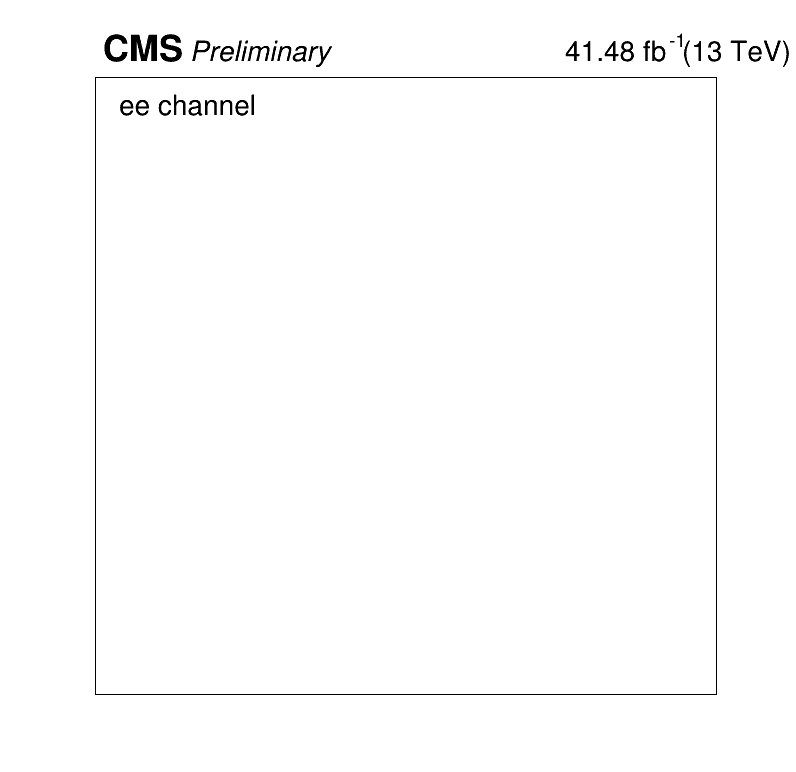

In [8]:
x = FloatVector([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975])
import math
for mass in masses:
    in_file = INPUTDIR+"/"+REGION+"/root_files/shape_v1_20230430wp80_ANv3"+mass+"_v1.root"
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"
    os.system("cp "+in_file+" "+out_file)

    f = rt.TFile(in_file)

    rt.gDirectory.cd("signal_region")

    processes = ["ttbar", "ww", "zp"]
#     list_sys = get_sys_list()
#     list_sys.remove("scale")
#     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "btagSF", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    # temp! without btagsf
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE"]
#     list_sys = ["scale"]
    print(list_sys)
    for sys in list_sys:
        c, dic_smooth = draw_sys_ratio_bysource(ERA, f, processes, sys, mass)
        if "met" in sys or "hdamp" in sys or "UE" in sys or "scale" in sys or "JEC" in sys:
            for process in processes:
                yup = FloatVector(dic_smooth[process+sys+'Up'])
                ydown = FloatVector(dic_smooth[process+sys+'Down'])
                n = dic_smooth[process+sys+'Nom']
                n1 = n
                if "scale" in sys and "e" in ERA:
                    n_data = dic_smooth[process+sys+'NomData']
                    n1 = n_data
                w = np.sqrt(n1)
                w = FloatVector(w)
                lup = limma.weightedLowess(x, yup, w, span=0.4, output_style="lowess")
                ldown = limma.weightedLowess(x, ydown, w, span=0.4, output_style="lowess")
                smoothed_up = np.array(lup[0])
                smoothed_up[np.isnan(smoothed_up)] = 1
                smoothed_down = np.array(ldown[0])
                print(process, n, yup, smoothed_up, smoothed_down)
                nbin = 20
                if "JEC" in sys:
                    h_Up = rt.TH1D(process+"_JESUp", process+"_JESUp", nbin, 0, 1)           
                    h_Down = rt.TH1D(process+"_JESDown", process+"_JESDown", nbin, 0, 1)   
                else:               
                    h_Up = rt.TH1D(process+"_"+sys+"_smoothedUp", process+"_"+sys+"_smoothedUp", nbin, 0, 1)           
                    h_Down = rt.TH1D(process+"_"+sys+"_smoothedDown", process+"_"+sys+"_smoothedDown", nbin, 0, 1)           
                for nb in range(nbin):
                    # average
                    avg = (math.fabs(1-smoothed_up[nb])+math.fabs(1-smoothed_down[nb]))/2
                    h_Up.SetBinContent(nb+1, n[nb]*(1+avg))
                    h_Down.SetBinContent(nb+1, n[nb]*(1-avg))
                    print((1+avg))
                    print((1-avg))
                write_sys_hist(out_file, h_Up, h_Down)

uncor: [0.03193379417130848, 0.027942499609925675, 0.027046874414580535, 0.026736394200290947, 0.02862475502943318, 0.029475188596622903, 0.030483760433646312, 0.030157085127793026, 0.030571452819913136, 0.03151914219135321, 0.028787023046667914, 0.029363846411920247, 0.027346580140580667, 0.027335666504994083, 0.029788962473351832, 0.0277411370851377, 0.028477968133574283, 0.02395930866396978, 0.027858070164549553, 0.029402990758105374]
cor: [0.0312686681745209, 0.028515091132899517, 0.028811495119779762, 0.030079214297006773, 0.03353668743977756, 0.036239800618273255, 0.0374578681440253, 0.03627245073500651, 0.033864752179976976, 0.03771158555420295, 0.03433010140515935, 0.03479220608856748, 0.030412380064888556, 0.03088010186100265, 0.035740810916466526, 0.03270759224017239, 0.032940335789266806, 0.02624904065501188, 0.030834693031968508, 0.03177886337157754]
quad u: [0.04469336 0.0399236  0.03951754 0.04024418 0.04409179 0.04671306
 0.04829443 0.04717139 0.04562275 0.04914896 0.044

Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345l1prefiring_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345pu_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345effrecoSF_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345ll_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345met_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345trig_eff_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345scale_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345metue_syst_by_source.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-3

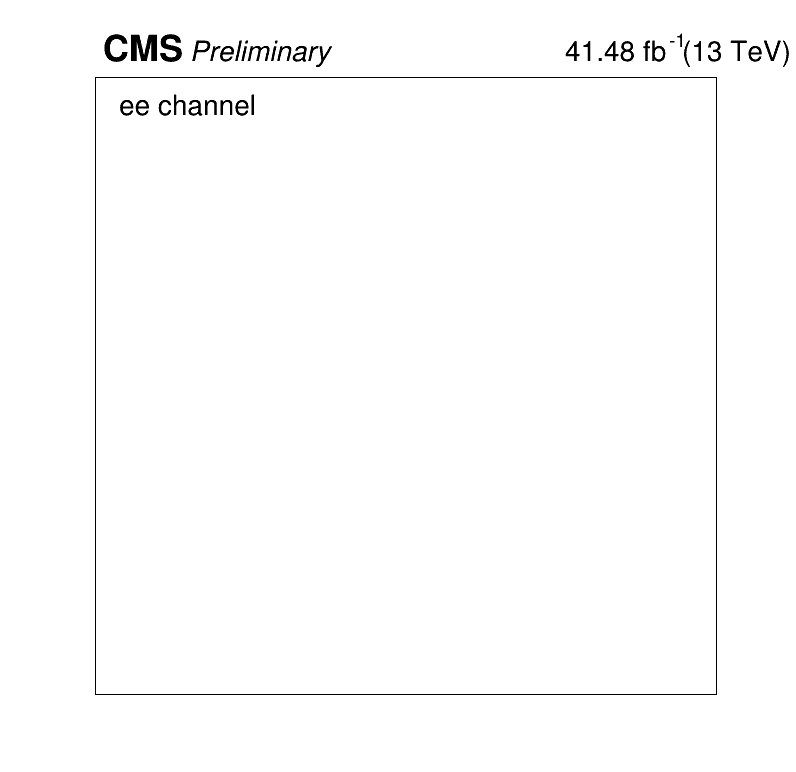

In [9]:
for mass in masses:
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

    f = rt.TFile(out_file)

    rt.gDirectory.cd("signal_region")

    processes = ["ttbar", "ww", "zp"]
#     processes = ["ttbar"]
#     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "btagSF", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    # temp! without btagsf
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE", "pdf", "muRF", "isr", "fsr"]
    list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "JEC", "JER", "metjer", "hdamp", "UE"]
#     list_sys = ["scale"]
    for sys in list_sys:
        c, dic_smooth = draw_sys_ratio_bysource(ERA, f, processes, sys, mass, True)


 # Draw by process

TFile**		Outputs/Syst/ee17/SR/root_files/shape_v1_20230430wp80_ANv3Zp-2500_CH-345_smoothed_v1.root	
 TFile*		Outputs/Syst/ee17/SR/root_files/shape_v1_20230430wp80_ANv3Zp-2500_CH-345_smoothed_v1.root	
  TDirectoryFile*		signal_region	signal_region
   KEY: TH1D	data_obs;1	data_obs
   KEY: TH1D	zp;1	zp
   KEY: TH1D	ttbar;1	ttbar
   KEY: TH1D	dy;1	dy
   KEY: TH1D	ww;1	ww
   KEY: TH1D	wz;1	wz
   KEY: TH1D	singletop;1	singletop
   KEY: TH1D	zz;1	zz
   KEY: TH1D	total_bkg;1	total_bkg
   KEY: TH1D	zp_puUp;1	zp_puUp
   KEY: TH1D	ttbar_puUp;1	ttbar_puUp
   KEY: TH1D	dy_puUp;1	dy_puUp
   KEY: TH1D	ww_puUp;1	ww_puUp
   KEY: TH1D	wz_puUp;1	wz_puUp
   KEY: TH1D	singletop_puUp;1	singletop_puUp
   KEY: TH1D	zz_puUp;1	zz_puUp
   KEY: TH1D	total_bkg_puUp;1	total_bkg_puUp
   KEY: TH1D	zp_puDown;1	zp_puDown
   KEY: TH1D	ttbar_puDown;1	ttbar_puDown
   KEY: TH1D	dy_puDown;1	dy_puDown
   KEY: TH1D	ww_puDown;1	ww_puDown
   KEY: TH1D	wz_puDown;1	wz_puDown
   KEY: TH1D	singletop_puDown;1	singletop_puDown
   KEY

Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345ttbarUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345ttbarDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345ttbarUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345ttbarDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345wwUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345wwDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345wwUp_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/AN/Zp-2500_CH-345wwDown_syst_by_process.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/Syst/ee17/SR/Zp-2500_CH-345zp

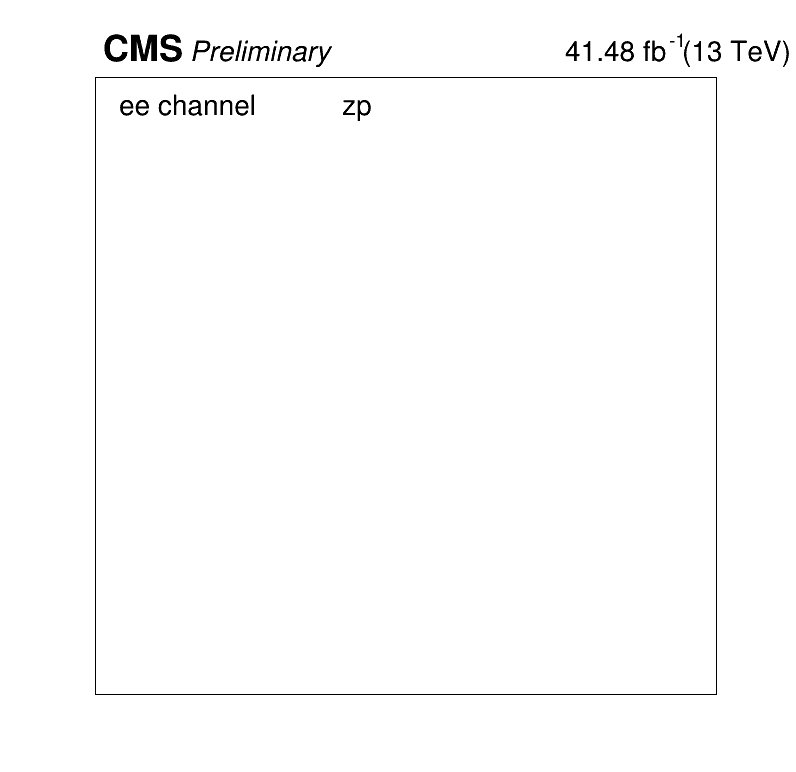

In [10]:
for mass in masses:
    out_file = out_dir+"/root_files/"+"shape_v1_20230430wp80_ANv3"+mass+"_smoothed_v1.root"

    f = rt.TFile(out_file)

    rt.gDirectory.cd("signal_region")

    processes = ["ttbar", "ww", "zp"]
#     processes = ["ttbar"]
#     list_sys = ["l1prefiring", "pu", "ll_eff", "met", "trig_eff", "toppt", "scale", "metue", "btagSF", "hdamp", "UE"]
    # list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue", "btagSF"]
    # temp! without btagsf
    list_sys = ["l1prefiring", "pu", "effrecoSF", "ll_eff", "met", "trig_eff", "scale", "metue"]
    for process in processes:
        c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = False)        
        c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Down", smoothed = False)        
        c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Up", smoothed = True)        
        c = draw_sys_ratio(ERA, f, process, list_sys, mass, updown="Down", smoothed = True)